# Verkenning en schoonmaken van de onbeschikbare geneesmiddelen 


In [1]:
import pandas as pd
from datetime import datetime as dt
import os

## Stap één: verkenning
Het eerste wat we gaan doen is de dataset inlezen en bekijken. We maken de columns mooi en isoleren de naam van het geneesmiddel om die later makkelijker terug te kunnen zoeken. Ook isoleren we het jaar van de startdatum om hier later makkelijker op te kunnen filteren.

In [2]:
data = pd.read_csv(os.path.expanduser('~/Desktop/vrtnws_data/zorg/supplyproblems.csv'), parse_dates=['Supply Problem Start Date', 'Supply Problem End Date'], dayfirst=True, error_bad_lines=True)
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')
data = data[data['human/veterinary'] == 'human']
data['name'] = data.name_medicinal_product.str.split().str.get(0)
data['start_year'] = pd.to_datetime(data.supply_problem_start_date, format='%Y-%m-%d').dt.year

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5626
Data columns (total 14 columns):
name_medicinal_product              5030 non-null object
pharmaceutical_form                 5030 non-null object
packaging_type                      5027 non-null object
pack_size                           5029 non-null object
mah                                 5030 non-null object
supply_problem_start_date           5030 non-null datetime64[ns]
supply_problem_presumed_end_date    3498 non-null object
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3634 non-null object
authorisation_number                5030 non-null object
cti_extended                        5030 non-null object
human/veterinary                    5030 non-null object
name                                5030 non-null object
start_year                          5030 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 589.5+ KB


In [4]:
data.head()

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
0,Amoxypen 1 g,Effervescent tablet,Tube,20 (2 x 10),Amophar,2015-01-01,NaN,2016-02-01,NaN,BE218127,218127-05,human,Amoxypen,2015
1,Amoxypen 1 g,Effervescent tablet,Tube,8,Amophar,2015-01-01,NaN,2016-02-01,NaN,BE218127,218127-01,human,Amoxypen,2015
2,Buccalin,Tablet,Packaging,7,Desma,2015-01-01,NaN,2015-11-11,NaN,BE079274,079274-01,human,Buccalin,2015
3,Desloratadine Actavis 5 mg,Film-coated tablet,Blister,50,Actavis Group Ptc Ehf,2015-01-01,NaN,2015-01-01,NaN,EU/1/11/745/007,413244-01,human,Desloratadine,2015
4,Desloratadine Actavis 5 mg,Film-coated tablet,Blister,100,Actavis Group Ptc Ehf,2015-01-01,NaN,2015-01-01,NaN,EU/1/11/745/009,413262-01,human,Desloratadine,2015


## Stap twee: schoonmaken
Het volgende dat we willen doen is de dataset schoonmaken. Er is namelijk een grote kans dat er fouten in de dataset zitten. Van degene van wie de dataset hebben gekregen, begrepen we dat er geen geneesmiddelen in de dataset moeten zitten die nog onbeschikbaar waren op 12-8-2019. Dit kunnen we controleren omdat we van de info weten dat er een column is met de 'supply problem end date'. Hier zouden dus geen lege waardes in moeten zitten.

In [5]:
len(data[data.supply_problem_end_date.isna()])

563

En nu blijkt dus dat we alsnog 563 geneesmiddelen hebben waar een einddatum ontbreekt. We gaan deze subset opslaan in een variabele om beter te kunnen bekijken.

In [6]:
no_end = data[data.supply_problem_end_date.isna()]

## Stap drie: cross-referencing
Van de website van het FAGG hebben we nog twee andere datasets gehaald, namelijk de dataset met momenteel onbeschikbare geneesmiddelen en de dataset met de historiek van wijzigingen, gebaseerd op informatie van de afgelopen 30 dagen. Deze wordt dus elke dag aangepast. De historiek-dataset is gedownload op 23-10-2019. We kunnen deze twee datasets gebruiken om de geneesmiddelen zonder einddatum mee te cross-checken. Wellicht dat er, ondanks het bericht dat we kregen, alsnog geneesmiddelen in de dataset zitten die nog altijd onbeschikbaar zijn. 

In [7]:
current = pd.read_csv(os.path.expanduser('~/Desktop/vrtnws_data/zorg/current_update.csv'), parse_dates=['SUPPLY PROBLEM START DATE', 'SUPPLY PROBLEM EXPECTED END DATE'], dayfirst=True)
current.columns = current.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')
changes = pd.read_csv('~/Desktop/vrtnws_data/zorg/changes_update.csv', parse_dates=['BEGINDATUM ONBESCHIKBAARHEID'], dayfirst=True)
changes.columns = changes.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')

Ook deze datasets kunnen fouten bevatten. Een veel voorkomende fout in datasets zijn ontbrekende dan wel duplicate waardes. Daarom moeten we op zoek naar een unieke ID om te controleren of onze datasets dubbele waardes bevatten. Daarvoor moeten we de info van de datasets bekijken. 

In [8]:
current.info()

changes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 13 columns):
name                                603 non-null object
authorisation_holder                603 non-null object
pharmaceutical_form                 603 non-null object
packaging_type                      603 non-null object
pack_size                           603 non-null object
cti_extended                        603 non-null object
cnk                                 603 non-null object
fmd_code                            603 non-null object
supply_problem_start_date           603 non-null datetime64[ns]
supply_problem_expected_end_date    602 non-null datetime64[ns]
supply_problem_reason               38 non-null object
parallel_distributor                0 non-null float64
derogation                          603 non-null object
dtypes: datetime64[ns](2), float64(1), object(10)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data col

Hier zien we dat beide datasets de column 'cti_extended' bevat, en als we terugscrollen zien we dat onze oorspronkelijke dataset deze ook bevat. Een rondje op Google leert ons dat CTI Extended een unieke code is die het FAGG aan een bepaalde verpakkingstype van een bepaald geneesmiddel meegeeft. Dat is dus precies wat we zoeken. 

In [9]:
len(current.index)

603

In [10]:
current.cti_extended.nunique()

603

In [11]:
len(changes.index)

669

In [12]:
changes.cti_extended.nunique()

541

Uit bovenstaande zien we dat de huidige onbeschikbare geneesmiddelen allemaal uniek zijn, terwijl er in de changes-dataset wel duplicaten zitten. Dit kan te verklaren zijn, maar we gaan die dataset voor nu wel even parkeren en beginnen met de current-dataset. We gaan kijken of er onder de geneesmiddelen zonder einddatum wellicht geneesmiddelen zitten die nu nog onbeschikbaar zijn. Dat doen we door de twee datasets te mergen en te kijken of er rijen zijn die in beide datasets voorkomen. Eerst moeten we controleren of de datasets een beetje te vergelijken zijn. Dat ze dezelfde columnnamen hebben wil niet zeggen dat ze ook op dezelfde manier de data hebben ingevoerd. 

In [13]:
no_end.head()

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
1591,Midazolam Mylan 5 mg/ml,Solution for injection,Ampoule,10 x 10 ml,Mylan,2016-12-30,2017-02-03,NaT,New batch(es) not yet available,BE339403,339403-04,human,Midazolam,2016
1616,"Zolmitriptan Teva Instant 2,5 mg",Orodispersible tablet,Blister,3,Teva Pharma Belgium,2017-01-05,2017-06-15,NaT,New batch(es) not yet available,BE365836,365836-02,human,Zolmitriptan,2017
1672,Lansoprazol Sandoz 30 mg,"Gastro-resistant capsule, hard",Bottle,56,Sandoz,2017-01-20,2017-01-27,NaT,NaN,BE281967,281967-03,human,Lansoprazol,2017
1702,Lidocaine Accord 20 mg/ml,Solution for injection,Ampoule,20 x 10 ml,Accord Healthcare,2017-02-01,2017-05-15,NaT,New batch(es) not yet available,BE479342,479342-02,human,Lidocaine,2017
1703,Lorazetop 1 mg,Tablet,Blister,60,Apotex Europe,2017-02-01,2019-02-01,NaT,Production problems,BE193602,193602-03,human,Lorazetop,2017


In [14]:
current.head()

,name,authorisation_holder,pharmaceutical_form,packaging_type,pack_size,cti_extended,cnk,fmd_code,supply_problem_start_date,supply_problem_expected_end_date,supply_problem_reason,parallel_distributor,derogation
0,"""Aacidexam 5 mg/ml""",Aspen Pharma Trading Ltd (IE),Solution for injection,"""Ampoule""",1 ml,080026-01,"""1750132""","""05060249176732""",2019-09-30,2019-12-07,NaN,NaN,no
1,"""Abacavir/Lamivudin Sandoz 600 mg - 300 mg""",Sandoz NV (BE),Film-coated tablet,"""Blister""",30,500622-01,"""3550647""","""07613421010430""",2019-03-01,2020-01-15,NaN,NaN,no
2,"""Accupril 40 mg""",Pfizer SA (BE),Film-coated tablet,"""Blister""",56,150963-01,"""1578129""","""05415062302880""",2019-08-22,2019-12-15,NaN,NaN,no
3,"""Accuretic 10 mg - 12,5 mg""",Pfizer SA (BE),Film-coated tablet,"""Blister""",28,164367-01,"""1088673""","""05415062302903""",2019-06-12,2019-10-31,NaN,NaN,no
4,"""Accuretic 20 mg - 12,5 mg""",Pfizer SA (BE),Film-coated tablet,"""Blister""",28,164376-01,"""1088681""","""05415062302910""",2018-11-22,2019-11-10,NaN,NaN,no


Er vallen een aantal dingen op. Zo hebben in de current-dataset een aantal waardes (name, packaging type) apostrofs om de inhoud gekregen. Dat maakt het onmogelijk om deze waardes te vergelijken met de andere dataset. We kunnen dit oplossen door de dataset aan te passen.

In [15]:
current['name'] = current.name.str.replace('"', '')
current['packaging_type'] = current.packaging_type.str.replace('"', '')

In [16]:
current.head()

,name,authorisation_holder,pharmaceutical_form,packaging_type,pack_size,cti_extended,cnk,fmd_code,supply_problem_start_date,supply_problem_expected_end_date,supply_problem_reason,parallel_distributor,derogation
0,Aacidexam 5 mg/ml,Aspen Pharma Trading Ltd (IE),Solution for injection,Ampoule,1 ml,080026-01,"""1750132""","""05060249176732""",2019-09-30,2019-12-07,NaN,NaN,no
1,Abacavir/Lamivudin Sandoz 600 mg - 300 mg,Sandoz NV (BE),Film-coated tablet,Blister,30,500622-01,"""3550647""","""07613421010430""",2019-03-01,2020-01-15,NaN,NaN,no
2,Accupril 40 mg,Pfizer SA (BE),Film-coated tablet,Blister,56,150963-01,"""1578129""","""05415062302880""",2019-08-22,2019-12-15,NaN,NaN,no
3,"Accuretic 10 mg - 12,5 mg",Pfizer SA (BE),Film-coated tablet,Blister,28,164367-01,"""1088673""","""05415062302903""",2019-06-12,2019-10-31,NaN,NaN,no
4,"Accuretic 20 mg - 12,5 mg",Pfizer SA (BE),Film-coated tablet,Blister,28,164376-01,"""1088681""","""05415062302910""",2018-11-22,2019-11-10,NaN,NaN,no


We zien dat we dat probleem nu hebben opgelost. Op deze manier kunnen we gaan mergen. We mergen de dataset in ieder geval op de cti_extended waarde én op de startdatum van de supply problems, om de kans te vergroten dat we dezelfde rijen te pakken hebben. We voegen ook een indicator toe, waar we op kunnen filteren als we willen zien welke rijen in beide datasets voorkomen. We doen een left join, omdat we ook willen weten welke waardes niet in beide datasets voorkomen, maar wel in de no_end dataset. 

In [17]:
merged = pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date'], how='left', indicator='exists')

In [18]:
merged.head()

,name_medicinal_product,pharmaceutical_form_x,packaging_type_x,pack_size_x,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason_x,authorisation_number,...,pharmaceutical_form_y,packaging_type_y,pack_size_y,cnk,fmd_code,supply_problem_expected_end_date,supply_problem_reason_y,parallel_distributor,derogation,exists
0,Midazolam Mylan 5 mg/ml,Solution for injection,Ampoule,10 x 10 ml,Mylan,2016-12-30,2017-02-03,NaT,New batch(es) not yet available,BE339403,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
1,"Zolmitriptan Teva Instant 2,5 mg",Orodispersible tablet,Blister,3,Teva Pharma Belgium,2017-01-05,2017-06-15,NaT,New batch(es) not yet available,BE365836,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
2,Lansoprazol Sandoz 30 mg,"Gastro-resistant capsule, hard",Bottle,56,Sandoz,2017-01-20,2017-01-27,NaT,NaN,BE281967,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
3,Lidocaine Accord 20 mg/ml,Solution for injection,Ampoule,20 x 10 ml,Accord Healthcare,2017-02-01,2017-05-15,NaT,New batch(es) not yet available,BE479342,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
4,Lorazetop 1 mg,Tablet,Blister,60,Apotex Europe,2017-02-01,2019-02-01,NaT,Production problems,BE193602,...,Tablet,Blister,60,"""3215894""","""08712755216002""",2019-12-31,NaN,NaN,no,both


In [19]:
merged.exists.value_counts()

left_only     322
both          241
right_only      0
Name: exists, dtype: int64

We zien dat er 322 rijen zijn die in beide datasets voorkomen. Om zeker te weten dat we allemaal rijen hebben die inderdaad hetzelfde zijn, mergen we nog een keer maar dan met twee extra variabeles.

In [20]:
pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date', 'packaging_type', 'pharmaceutical_form'], how='left', indicator='exists').exists.value_counts()

left_only     327
both          236
right_only      0
Name: exists, dtype: int64

We zien dat er een verschil is van vijf waardes. Al we willen weten welke waardes dat zijn moeten we de twee datasets met elkaar vergelijken om het verschil te zien. Dat doen we door eerst van beide datasets de rijen te isoleren die in beide sets zouden voorkomen. 

In [21]:
merged_2 = pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date', 'packaging_type', 'pharmaceutical_form'], how='left', indicator='exists')

In [22]:
both = merged[merged.exists == 'both']
both_2 = merged_2[merged_2.exists == 'both']

In [23]:
pd.concat([both, both_2]).loc[
    both.index.symmetric_difference(both_2.index)
]

/Users/fmeijer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,authorisation_holder,authorisation_number,cnk,cti_extended,derogation,exists,fmd_code,human/veterinary,mah,name_medicinal_product,...,pharmaceutical_form,pharmaceutical_form_x,pharmaceutical_form_y,start_year,supply_problem_end_date,supply_problem_expected_end_date,supply_problem_presumed_end_date,supply_problem_reason_x,supply_problem_reason_y,supply_problem_start_date
60,Merck Sharp & Dohme BV (NL),EU/1/03/262/011,"""3621158""",490435-01,no,both,"""""",human,Merck Sharp & Dohme,Emend 125 mg,...,NaN,Powder for oral suspension,Powder for oral suspension,2018,NaT,2019-11-18,2019-07-31,Production problems,New batch(es) not yet available,2018-11-01
201,Pharmaswiss Ceska Republika SRO (CZ),BE108516,"""1204965""",108516-01,no,both,"""""",human,Pharmaswiss Ceska Republika,Duracef 500 mg/5 ml,...,NaN,Powder for oral suspension,Powder for oral suspension,2019,NaT,2019-12-31,2019-06-28,Production problems,NaN,2019-04-30
234,Pfizer SA (BE),BE291706,"""2473809""",291706-01,no,both,"""""",human,Pfizer,Mencevax ACWY,...,NaN,Powder and solvent for solution for injection,Powder and solvent for solution for injection,2019,NaT,2019-12-31,2019-07-30,New batch(es) not yet available,NaN,2019-05-23
301,Theramex Ireland Ltd (IE),BE223237,"""1634948""",223237-02,no,both,"""05407003822441""",human,Theramex Ireland,Feminova Plus 50mcg/10mcg/24hrs,...,NaN,Transdermal patch,"Transdermal patch, Transdermal patch",2019,NaT,2019-12-31,2019-12-31,Production problems,NaN,2019-06-10
489,Sanofi Pasteur Europe SA (FR),BE158724,"""0320879""",158724-01,no,both,"""03664798005196""",human,Sanofi Pasteur Europe,"Act-HIB 10 µg/0,5 ml",...,NaN,Powder and solvent for solution for injection,Powder and solvent for solution for injection,2019,NaT,2019-12-31,2019-08-22,Production problems,NaN,2019-07-23


In [24]:
values = pd.concat([both, both_2]).loc[
    both.index.symmetric_difference(both_2.index)
]

/Users/fmeijer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [26]:
values[['cti_extended', 'supply_problem_start_date', 'packaging_type_x', 'packaging_type', 'packaging_type_y', 'pharmaceutical_form_x', 'pharmaceutical_form', 'pharmaceutical_form_y']]

,cti_extended,supply_problem_start_date,packaging_type_x,packaging_type,packaging_type_y,pharmaceutical_form_x,pharmaceutical_form,pharmaceutical_form_y
60,490435-01,2018-11-01,Sachet,NaN,"Sachet, undefined, undefined",Powder for oral suspension,NaN,Powder for oral suspension
201,108516-01,2019-04-30,Container,NaN,Bottle,Powder for oral suspension,NaN,Powder for oral suspension
234,291706-01,2019-05-23,Pre-filled syringe / Vial,NaN,"Vial, Pre-filled syringe",Powder and solvent for solution for injection,NaN,Powder and solvent for solution for injection
301,223237-02,2019-06-10,Sachet,NaN,"Sachet, Sachet",Transdermal patch,NaN,"Transdermal patch, Transdermal patch"
489,158724-01,2019-07-23,Vial,NaN,"Vial, Vial",Powder and solvent for solution for injection,NaN,Powder and solvent for solution for injection


Nu zien we waar de mismatch vandaan komt: er zitten dubbelingen in de packaging_type_y en pharmaceutical_form_y (afkomstig van de 'current' dataset) die niet matchen met de oorspronkelijke dataset. Ondanks die fout lijken de waardes verder wel hetzelfde te zijn, en dus disregarden we deze wijzigingen en gaan we verder met onze oorspronkelijke dataset 'merged'.

We hebben de waardes die in beide datasets voorkomen al geïsoleerd uit deze dataset: 271 geneesmiddelen uit onze oorspronkelijke dataset zijn blijkbaar nog steeds onbeschikbaar. Dat betekent wel dat er nog 292 waardes overblijven waarvan we niet weten wat ermee gebeurd is. Het kan zijn dat ze in de tussentijd weer beschikbaar zijn geworden, maar dat weten we niet zeker. Het kan immers ook een fout zijn die bij de makers van de dataset ligt. 

Gelukkig hebben we nog een andere dataset die we kunnen cross-checken: die van de 'changes'. Dat is de historiek met wijzigingen van de afgelopen dertig dagen (gedownload op 02-11-2019). Laten we die dus eerst nog eens beter bekijken. 

In [25]:
changes.head()

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
0,"""1-Alpha Leo 0,25 µg""","Capsule, zacht",Blisterverpakking,30,118456-01,676569.0,"""05702191018165""",Leo Pharma NV,2019-09-13,2019-10-11,,NaN,Terug beschikbaar
1,"""1-Alpha Leo 1 µg""","Capsule, zacht",Blisterverpakking,50,233834-02,18531.0,"""05702191018158""",Leo Pharma NV,2019-08-19,2019-10-10,,NaN,Terug beschikbaar
2,"""1-Alpha Leo IV 1 µg/0,5 ml""",Oplossing voor injectie,Blisterverpakking,10 x 0.5 ml,164595-01,1128719.0,"""05702191019353""",Leo Pharma NV,2018-10-03,2020-01-17,,NaN,Terug beschikbaar
3,"""Accupril 40 mg""",Filmomhulde tablet,Blisterverpakking,56,150963-01,1578129.0,"""05415062302880""",Pfizer SA,2019-08-22,2019-12-15,,NaN,Vermoedelijke einddatum gewijzigd
4,"""Accupril 40 mg""",Filmomhulde tablet,Blisterverpakking,56,150963-01,1578129.0,"""05415062302880""",Pfizer SA,2019-08-22,2019-11-05,,NaN,Vermoedelijke einddatum gewijzigd


We zien dat er een 'reden_delta' column bestaat, waar de reden voor de wijziging in staat opgenomen. We zien ook al een aantal keer 'terug beschikbaar' staan. Dat is dus het eerste waar we naar gaan kijken. Maar eerst:

Let op: we hadden net geconcludeerd dat er dubbelingen in deze dataset zitten, op basis van een check van de ID's. We moeten dus ook uitzoeken waar deze dubbelingen vandaan komen. 

In [26]:
len(changes[changes.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid'])].index)

123

Een mogelijke verklaring voor de dubbelingen is dat de changes-dataset een cumulatieve dataset is, waar alle wijzigingen in blijven staan. Dan kan een geneesmiddel dus meerdere entries hebben, bijvoorbeeld zowel als de einddatum wijzigt als wanneer deze opnieuw beschikbaar is. Dat kunnen we controleren door een groupby te doen op de cti_extended en de startdatum van de onbeschikbaarheid en te tellen hoeveel unieke waardes in de column 'reden_delta' voorkomen. 

In [27]:
changes.groupby(['cti_extended', 'begindatum_onbeschikbaarheid']).reden_delta.nunique().sort_values(ascending=False)

cti_extended  begindatum_onbeschikbaarheid
445840-04     2019-07-13                      3
106093-01     2019-05-03                      3
187512-04     2019-10-04                      3
305602-04     2019-10-11                      3
244711-01     2019-06-24                      2
356614-03     2019-10-07                      2
436861-08     2019-04-24                      2
354392-03     2019-08-06                      2
439171-04     2019-09-20                      2
439171-05     2019-07-10                      2
349194-01     2019-10-17                      2
441883-07     2019-03-08                      2
235864-01     2019-09-06                      2
235864-02     2019-09-26                      2
340611-08     2019-08-22                      2
240186-01     2019-08-19                      2
249085-10     2019-10-09                      2
431654-01     2019-05-14                      2
147576-03     2019-08-06                      2
146562-01     2019-09-26                     

In [28]:
changes[(changes.cti_extended == '283534-01') & (changes.begindatum_onbeschikbaarheid == '2019-09-25')]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
389,"""Nanogam 50 mg/ml""",Oplossing voor infusie,Injectieflacon,200 ml,283534-01,2520575.0,"""08717185832143""",Sanquin Plasma ProductsBV,2019-09-25,2019-10-31,,NaN,Terug beschikbaar
390,"""Nanogam 50 mg/ml""",Oplossing voor infusie,Injectieflacon,200 ml,283534-01,2520575.0,"""08717185832143""",Sanquin Plasma ProductsBV,2019-09-25,2019-10-31,,NaN,Vermoedelijke einddatum gewijzigd


Nu zien we inderdaad dat het een cumulatieve dataset betreft. En nu we dit weten, kunnen we de datasets met elkaar gaan vergelijken. Eerst isoleren we de overgebleven waardes uit merged, en dan vergelijken we die als eerste met de geneesmiddelen in de historiek waarvan we weten dat die opnieuw beschikbaar zijn geworden in de afgelopen 30 dagen. 

In [29]:
leftovers = merged[merged.exists != 'both']

In [30]:
leftovers = leftovers.drop(columns=['name_y', 'authorisation_holder', 'pharmaceutical_form_y', 'packaging_type_y', 'pack_size_y', 'cnk', 'fmd_code', 'supply_problem_expected_end_date', 'supply_problem_reason_y', 'parallel_distributor', 'derogation', 'exists'])

In [31]:
leftovers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 561
Data columns (total 14 columns):
name_medicinal_product              322 non-null object
pharmaceutical_form_x               322 non-null object
packaging_type_x                    321 non-null object
pack_size_x                         322 non-null object
mah                                 322 non-null object
supply_problem_start_date           322 non-null datetime64[ns]
supply_problem_presumed_end_date    314 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason_x             317 non-null object
authorisation_number                322 non-null object
cti_extended                        322 non-null object
human/veterinary                    322 non-null object
name_x                              322 non-null object
start_year                          322 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 37.7+ KB


In [32]:
available = changes[changes.reden_delta == 'Terug beschikbaar']

Ook hier moeten we controleren of er dubbelingen in de subset zitten. Dat doen we als volgt: 

In [33]:
available[available.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid', 'verpakkingstype', 'farmaceutische_vorm'])]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
85,"""Budesonide Teva 0,5 mg/ml""",Vernevelsuspensie,Ampul,20 x 2 ml,445840-04,3116308.0,"""05407003820799""",Teva Pharma BelgiumNV,2019-07-13,2019-10-14,,NaN,Terug beschikbaar
119,"""Clarithromycin Krka 500 mg""",Filmomhulde tablet,Blisterverpakking,20,503360-05,3566759.0,"""03838989676384""","Krka, D.D. Novo Mesto",2019-05-24,2019-11-30,,NaN,Terug beschikbaar
154,"""Corsodyl 2 mg/ml""",Mondspoeling,Fles,200 ml,106802-02,NaN,"""""",Glaxosmithkline Consumer Healthcare SA,2019-10-15,2019-12-02,,NaN,Terug beschikbaar
373,"""Mitomycine-C Kyowa 10 mg""",Poeder voor oplossing voor injectie,Injectieflacon,3 x 10 mg,123322-01,827600.0,"""07038319110328""",Takeda Belgium Comm. VA NV,2019-07-23,2019-11-30,,NaN,Terug beschikbaar
375,"""Mitomycine-C Kyowa 2 mg""",Poeder voor oplossing voor injectie,Injectieflacon,10 x 2 mg,085985-01,57679.0,"""07038319110311""",Takeda Belgium Comm. VA NV,2019-08-22,2019-11-30,,NaN,Terug beschikbaar
377,"""Mitomycine-C Kyowa 20 mg""",Poeder voor oplossing voor intravesicaal gebruik,Injectieflacon,2 x 20 mg,131923-01,856054.0,"""07038319110335""",Takeda Belgium Comm. VA NV,2019-07-23,2019-11-30,,NaN,Terug beschikbaar
449,"""Parlodel 2,5 mg""",Tablet,Blisterverpakking,30,106093-01,66266.0,"""05099151914668""",Mylan EPDBVBA,2019-05-03,2019-10-21,,NaN,Terug beschikbaar


Er blijken inderdaad duplicates in te zitten en dus gaan we die eerst eruit halen. Dan kunnen we deze subset mergen met de leftovers dataset. 

In [34]:
available_clean = available.drop_duplicates(['cti_extended', 'begindatum_onbeschikbaarheid', 'verpakkingstype', 'verpakkingsgrootte'])

In [35]:
available_clean[available_clean.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid'])]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta


In [36]:
more_leftovers = pd.merge(leftovers, available_clean, how='outer', left_on=['cti_extended', 'supply_problem_start_date'], right_on=['cti_extended', 'begindatum_onbeschikbaarheid'], indicator='exists')

In [37]:
more_leftovers.exists.value_counts()

left_only     248
right_only    120
both           74
Name: exists, dtype: int64

We houden nu 248 waardes over die alleen in leftovers voorkomen. We hebben een overlap van 120 waardes, dat zijn dus 120 geneesmiddelen uit de originele dataset die weer beschikbaar zijn geworden in de afgelopen 30 dagen. En er zijn nog 93 waardes die alleen in de historiek voorkomen, dat wil zeggen dat deze geneesmiddelen waarschijnlijk een startdatum na 12-8-2019 hadden, maar inmiddels al wel weer beschikbaar zijn, en om die reden momenteel niet in de dataset zitten. Dat is iets wat we nog moeten bekijken, want we willen natuurlijk een zo volledig mogelijk beeld hebben. Deze gaan we dus even opzij zetten in een andere variabele.

In [38]:
available_others = more_leftovers[more_leftovers.exists == 'right_only']

We willen natuurlijk ook kijken naar de geneesmiddelen die weer beschikbaar zijn, want die hebben we wellicht nodig om onze primaire dataset mee te updaten. We weten dan nog niet op welke datum ze precies weer beschikbaar zijn geworden, en dat is wel vervelend. We moeten dat dus nog navragen, maar dat doen we eenvoudiger als we een csv hebben met de 77 geneeesmiddelen uit de dataset waarvan we weten dat ze inmiddels weer beschikbaar zijn.

In [39]:
more_leftovers[more_leftovers.exists == 'both'].to_csv('zorg/weer_beschikbaar_update.csv', index=False)

We gaan ook nog even verder kijken naar de overgebleven geneesmiddelen. Wellicht dat de rest van de changes-dataset hier ons meer over kan vertellen.

In [40]:
even_more_lo = more_leftovers[(more_leftovers.exists != 'both') & (more_leftovers.exists != 'right_only')]

In [41]:
len(even_more_lo.index)

248

In [42]:
even_more_lo = even_more_lo.drop(columns=['benaming', 'farmaceutische_vorm', 'verpakkingstype', 'verpakkingsgrootte', 'cnk', 'fmd_code', 'vergunninghouder', 'begindatum_onbeschikbaarheid', 'vermoedelijke_einddatum_onbeschikbaarheid', 'reden_onbeschikbaarheid', 'parallel_verdeler', 'reden_delta', 'exists'])

We halen alle waardes uit changes die niet overeenkomen met de reden_delta 'terug beschikbaar'. Ook hier zullen dubbelingen in zitten, dus we moeten de set eerst opschonen. 

In [43]:
others = changes[changes.reden_delta != 'Terug beschikbaar']

In [44]:
others_clean = others.drop_duplicates(['cti_extended', 'begindatum_onbeschikbaarheid', 'verpakkingstype', 'verpakkingsgrootte', 'cnk', 'fmd_code'])

In [45]:
others_clean[others_clean.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid'])]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta


In [46]:
len(others_clean.index)

427

In [47]:
others_clean.cti_extended.nunique()

422

In [48]:
others_clean[others_clean.duplicated(['cti_extended'])]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
75,"""Baclofen Mylan 10 mg""",Tablet,Blisterverpakking,50,152704-01,1559657.0,"""05099151910134""",Mylan SPRL,2019-10-07,2019-10-27,,NaN,Nieuwe onbeschikbaarheid
230,"""Fibclot 1,5 g""",Poeder en oplosmiddel voor oplossing voor inje...,"Injectieflacon, Injectieflacon",1.5 g + 100 ml,489955-01,3613163.0,"""03700386800160""",Laboratoire Français du Fractionnement et des ...,2019-05-16,2020-04-30,,NaN,Vermoedelijke einddatum gewijzigd
550,"""Sildenafil Apotex 100 mg""",Filmomhulde tablet,Blisterverpakking,24,380992-06,3087871.0,"""08712755217153""",Apotex Europe BV,2018-07-09,2019-12-31,,NaN,Vermoedelijke einddatum gewijzigd
631,"""Valtran 71,197 mg/ml - 6,083 mg/ml""","Druppels voor oraal gebruik, oplossing",Fles,60 ml,118517-03,1499185.0,"""05415062313824""",Pfizer SA,2019-07-18,2019-10-15,,NaN,Vermoedelijke einddatum gewijzigd
634,"""Valtran Retard 50 mg - 4 mg""",Tablet met verlengde afgifte,Fles,60,211093-03,2086916.0,"""05415062313848""",Pfizer SA,2019-10-09,2019-12-10,,NaN,Nieuwe onbeschikbaarheid


In [49]:
others_clean[others_clean.cti_extended == '118517-03']

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
629,"""Valtran 71,197 mg/ml - 6,083 mg/ml""","Druppels voor oraal gebruik, oplossing",Fles,60 ml,118517-03,1499185.0,"""05415062313824""",Pfizer SA,2019-10-17,2019-11-11,,NaN,Nieuwe onbeschikbaarheid
631,"""Valtran 71,197 mg/ml - 6,083 mg/ml""","Druppels voor oraal gebruik, oplossing",Fles,60 ml,118517-03,1499185.0,"""05415062313824""",Pfizer SA,2019-07-18,2019-10-15,,NaN,Vermoedelijke einddatum gewijzigd


In [50]:
leftovers_final = pd.merge(even_more_lo, others_clean, how='left', left_on=['cti_extended', 'supply_problem_start_date'], right_on=['cti_extended', 'begindatum_onbeschikbaarheid'], indicator='exists')

In [51]:
leftovers_final.exists.value_counts()

left_only     247
both            1
right_only      0
Name: exists, dtype: int64

We hebben nog één overlap over. Dat wil zeggen dat we 247 waardes hebben waar we op dit moment geen uitsluitsel over kunnen geven wat daar de huidige status van is. Het kan zijn dat ze alweer beschikbaar zijn, maar we weten het niet zeker. Dat moeten we dus navragen bij de makers van de dataset. 

### UPDATE: we hebben op 28-10-2019 een dataset gekregen met alle medicijnen die weer beschikbaar zijn geworden tussen 12-8-2019 en 28-10-2019. Hopelijk vinden we daar de ontbrekende waardes.

In [52]:
lastresort = pd.read_csv('zorg/lastresort.csv', sep=';', parse_dates=['StartDate', 'EndDate'], dayfirst=True)

In [53]:
lastresort.columns = lastresort.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')

In [54]:
lastresort.head()

,name,packsize,cnk,reason,startdate,enddate
0,Olanzapine Sandoz 5 mg,28,2970051,New batch(es) not yet available,2019-07-30,2019-08-12
1,Clarithromycin Sandoz 125 mg/5 ml,60 ml,2916526,New batch(es) not yet available,2019-06-27,2019-08-12
2,Piroxicam Sandoz 20 mg,30,1738988,New batch(es) not yet available,2019-06-19,2019-08-12
3,Clarithromycin Sandoz 125 mg/5 ml,120 ml,2916534,New batch(es) not yet available,2019-06-12,2019-08-12
4,Pyralvex 50 mg/ml,10 ml,127035,New batch(es) not yet available,2019-06-21,2019-08-12


In [55]:
leftovers_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 0 to 247
Data columns (total 27 columns):
name_medicinal_product                       248 non-null object
pharmaceutical_form_x                        248 non-null object
packaging_type_x                             248 non-null object
pack_size_x                                  248 non-null object
mah                                          248 non-null object
supply_problem_start_date                    248 non-null datetime64[ns]
supply_problem_presumed_end_date             240 non-null object
supply_problem_end_date                      0 non-null datetime64[ns]
supply_problem_reason_x                      243 non-null object
authorisation_number                         248 non-null object
cti_extended                                 248 non-null object
human/veterinary                             248 non-null object
name_x                                       248 non-null object
start_year                          

We gaan nu eerst de overgebleven waardes uit de leftovers set isoleren en dan deze nog wat opschonen, zodat er niet een heleboel lege columns in de set zitten.

In [56]:
last_leftovers = leftovers_final[leftovers_final.exists != 'both']

In [57]:
last_leftovers = last_leftovers.drop(columns=['benaming', 'farmaceutische_vorm', 'verpakkingstype', 'verpakkingsgrootte', 'cnk', 'fmd_code', 'vergunninghouder', 'begindatum_onbeschikbaarheid', 'vermoedelijke_einddatum_onbeschikbaarheid', 'reden_onbeschikbaarheid', 'parallel_verdeler', 'reden_delta', 'exists'])

In [58]:
lastresort[lastresort.duplicated(['cnk', 'packsize', 'startdate'])]

,name,packsize,cnk,reason,startdate,enddate


We moeten zeker weten dat we op iets mergen waar geen duplicates in zitten, zodat we daar geen fouten mee kunnen krijgen. Dit werkt.

In [59]:
final_merge = pd.merge(last_leftovers, lastresort, left_on=['name_medicinal_product', 'supply_problem_start_date', 'pack_size_x'], right_on=['name', 'startdate', 'packsize'], how='left', indicator='exists')

In [63]:
final_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 246
Data columns (total 21 columns):
name_medicinal_product              247 non-null object
pharmaceutical_form_x               247 non-null object
packaging_type_x                    247 non-null object
pack_size_x                         247 non-null object
mah                                 247 non-null object
supply_problem_start_date           247 non-null datetime64[ns]
supply_problem_presumed_end_date    239 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason_x             242 non-null object
authorisation_number                247 non-null object
cti_extended                        247 non-null object
human/veterinary                    247 non-null object
name_x                              247 non-null object
start_year                          247 non-null float64
name                                179 non-null object
packsize                            179 

In [60]:
final_merge.exists.value_counts()

both          179
left_only      68
right_only      0
Name: exists, dtype: int64

We zien een overlap van 179 waardes. Dat betekent dat er nog steeds 68 waardes overblijven die niet tussen 12-8-2019 en nu terug beschikbaar zijn geworden. We zullen terug moeten gaan naar de makers van de dataset om de overgebleven 67 waardes op te laten helderen. 

In [61]:
undecided = final_merge[final_merge.exists != 'both']

In [62]:
undecided.to_csv('zorg/onbeslist_update.csv', index=False)

## Stap vijf: verdere exploratie van de dataset

Nu we de dataset voor een deel hebben verkend op fouten en ontbrekende waardes, kunnen we even verder kijken naar de variabele die we net opzij hebben gezet: namelijk de subset van 'available' (de geneesmiddelen die weer beschikbaar zijn) die niet in onze dataset zaten. Laten we even kijken naar deze set. 

In [63]:
available_others = available_others.drop(columns=['name_medicinal_product', 'pharmaceutical_form_x', 'packaging_type_x', 'pack_size_x', 'mah', 'supply_problem_start_date', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason_x', 'authorisation_number', 'human/veterinary', 'name_x', 'start_year'])

In [64]:
available_others.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 322 to 441
Data columns (total 14 columns):
cti_extended                                 120 non-null object
benaming                                     120 non-null object
farmaceutische_vorm                          120 non-null object
verpakkingstype                              120 non-null object
verpakkingsgrootte                           120 non-null object
cnk                                          119 non-null float64
fmd_code                                     120 non-null object
vergunninghouder                             120 non-null object
begindatum_onbeschikbaarheid                 120 non-null datetime64[ns]
vermoedelijke_einddatum_onbeschikbaarheid    120 non-null object
reden_onbeschikbaarheid                      120 non-null object
parallel_verdeler                            0 non-null float64
reden_delta                                  120 non-null object
exists                                  

In [65]:
available_others.head()

,cti_extended,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta,exists
322,118456-01,"""1-Alpha Leo 0,25 µg""","Capsule, zacht",Blisterverpakking,30,676569.0,"""05702191018165""",Leo Pharma NV,2019-09-13,2019-10-11,,NaN,Terug beschikbaar,right_only
323,233834-02,"""1-Alpha Leo 1 µg""","Capsule, zacht",Blisterverpakking,50,18531.0,"""05702191018158""",Leo Pharma NV,2019-08-19,2019-10-10,,NaN,Terug beschikbaar,right_only
324,225556-01,"""Aciclovir Sandoz 800 mg""",Tablet,Blisterverpakking,35,1679000.0,"""07613421010119""",Sandoz NV,2019-09-13,2019-11-08,,NaN,Terug beschikbaar,right_only
325,415983-03,"""Acidcare 10 mg""","Maagsapresistente capsule, hard",Tablettencontainer,14,2976843.0,"""03838957081707""",Sandoz NV,2019-08-21,2019-10-29,,NaN,Terug beschikbaar,right_only
326,244535-05,"""Actonel 35 mg Wekelijks """,Filmomhulde tablet,Blisterverpakking,12,1768548.0,"""05407003820041""",Theramex IrelandLtd,2019-06-06,2019-10-11,,NaN,Terug beschikbaar,right_only


In [66]:
len(available_others[available_others.begindatum_onbeschikbaarheid > '2019-08-12'])

107

We hebben dus 107 geneesmiddelen met een startdatum later dan 12-8-2019. Deze geneesmiddelen zijn inmiddels ook alweer beschikbaar, maar voor de volledigheid van de dataset willen we toch weten welke geneesmiddelen dit zijn zodat we ze kunnen toevoegen aan de oorspronkelijke dataset. We zetten ze dus apart in een variabele die we hopelijk later terug kunnen voegen bij de hoofd-dataset. 

In [67]:
late_start = available_others[available_others.begindatum_onbeschikbaarheid > '2019-08-12']

Hoe zit het met die andere geneesmiddelen? Het zijn er niet zo veel, dus we kunnen ze zo wel even bekijken om te zien of er iets bijzonders aan is. 

In [68]:
available_others[available_others.begindatum_onbeschikbaarheid <= '2019-08-12'].sort_values(by='begindatum_onbeschikbaarheid', ascending=False)

,cti_extended,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta,exists
359,051563-01,"""Fenistil 0.1 %""","Druppels voor oraal gebruik, oplossing",Container met druppelpipet,20 ml,2565950.0,"""""",Glaxosmithkline Consumer Healthcare SA,2019-08-12,2019-10-21,,NaN,Terug beschikbaar,right_only
403,510044-01,"""Perindopril Teva 2,5 mg""",Filmomhulde tablet,Verpakking,30,3624012.0,"""05407003824308""",Teva Pharma BelgiumNV,2019-08-08,2019-10-15,,NaN,Terug beschikbaar,right_only
426,329052-01,"""Toviaz 8 mg""",Tablet met verlengde afgifte,Blisterverpakking,84,2493211.0,"""05415062326268""",Pfizer Europe MA EEIG,2019-08-08,2019-10-11,,NaN,Terug beschikbaar,right_only
354,210183-02,"""Emconcor Minor 2,5 mg""",Filmomhulde tablet,Blisterverpakking,28,1552017.0,"""04054839256615""",Merck NV,2019-08-06,2019-11-18,,NaN,Terug beschikbaar,right_only
436,147576-03,"""Xanax 2 mg""",Tablet,Fles,50,676593.0,"""05415062303191""",Pfizer SA,2019-08-06,2019-10-21,,NaN,Terug beschikbaar,right_only
350,422204-01,"""Docetaxel Accord 160 mg/8 ml""",Concentraat voor oplossing voor infusie,Injectieflacon,8 ml,3012911.0,"""05055565750995""",Accord Healthcare S.L.USL,2019-08-05,2019-10-08,,NaN,Terug beschikbaar,right_only
352,071827-03,"""Duspatalin 135 mg""",Omhulde tablet,Tablettencontainer,120,1082346.0,"""05099151913241""",Mylan EPDBVBA,2019-07-29,2019-11-11,,NaN,Terug beschikbaar,right_only
370,001215-03,"""Imodium 2 mg""","Capsule, hard",Blisterverpakking,200,433276.0,"""03574661243788""",Johnson & Johnson Consumer NV,2019-07-19,2019-10-08,,NaN,Terug beschikbaar,right_only
382,314465-07,"""Losartan Teva 50 mg""",Filmomhulde tablet,Blisterverpakking,98,2601649.0,"""05407003823080""",Teva Pharma BelgiumNV,2019-07-16,2019-10-30,,NaN,Terug beschikbaar,right_only
338,445840-04,"""Budesonide Teva 0,5 mg/ml""",Vernevelsuspensie,Ampul,20 x 2 ml,3116308.0,"""05407003820799""",Teva Pharma BelgiumNV,2019-07-13,2019-10-31,,NaN,Terug beschikbaar,right_only


Controle in het Excel-bestand laat zien dat deze waardes inderdaad allemaal niet in de dataset zitten. Het gaat hier dus om geneesmiddelen die op of voor 12-8-2019 onbeschikbaar zijn geworden en op 12-8-2019 nog niet beschikbaar waren, maar ergens tussen 12-8-2019 en 23-10-2019 weer wel beschikbaar zijn geworden. Ook hierover zullen we nog navraag moeten doen bij de makers van de dataset: is het mogelijk een dataset te krijgen met de geneesmiddelen die nog onbeschikbaar waren op 12-8-2019, maar inmiddels wel weer beschikbaar zijn geworden?

Dat brengt ons ook op de vraag hoe het precies zit met de geneesmiddelen die nog onbeschikbaar zijn, maar niet in onze oorspronkelijke dataset zijn opgenomen. 

In [69]:
pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date'], how='right', indicator='exists').exists.value_counts()

right_only    362
both          241
left_only       0
Name: exists, dtype: int64

In [70]:
len(current.index)

603

Er zijn dus 362 waardes in de 'current' dataset die niet in onze hoofddataset voorkomen. Even kijken wat voor waardes dat zijn.

In [71]:
others_current = pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date'], how='right', indicator='exists')
others_current = others_current[others_current.exists != 'both']

In [72]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 241 to 602
Data columns (total 26 columns):
name_medicinal_product              0 non-null object
pharmaceutical_form_x               0 non-null object
packaging_type_x                    0 non-null object
pack_size_x                         0 non-null object
mah                                 0 non-null object
supply_problem_start_date           362 non-null datetime64[ns]
supply_problem_presumed_end_date    0 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason_x             0 non-null object
authorisation_number                0 non-null object
cti_extended                        362 non-null object
human/veterinary                    0 non-null object
name_x                              0 non-null object
start_year                          0 non-null float64
name_y                              362 non-null object
authorisation_holder                362 non-null object
phar

In [73]:
others_current = others_current.drop(columns=['name_medicinal_product', 'pharmaceutical_form_x', 'packaging_type_x', 'pack_size_x', 'mah', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason_x', 'authorisation_number', 'human/veterinary', 'name_x', 'start_year'])

In [74]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 241 to 602
Data columns (total 14 columns):
supply_problem_start_date           362 non-null datetime64[ns]
cti_extended                        362 non-null object
name_y                              362 non-null object
authorisation_holder                362 non-null object
pharmaceutical_form_y               362 non-null object
packaging_type_y                    362 non-null object
pack_size_y                         362 non-null object
cnk                                 362 non-null object
fmd_code                            362 non-null object
supply_problem_expected_end_date    362 non-null datetime64[ns]
supply_problem_reason_y             32 non-null object
parallel_distributor                0 non-null float64
derogation                          362 non-null object
exists                              362 non-null category
dtypes: category(1), datetime64[ns](2), float64(1), object(10)
memory usage: 40.0+ KB


In [75]:
len(others_current[others_current.supply_problem_start_date > '2019-08-12'])

320

Er zijn dus 320 geneesmiddelen met een startdatum na 12-08-2019, wat zou kunnen verklaren waarom ze er niet in zijn opgenomen. We willen dus een dataset met alle geneesmiddelen erin, ook met een startdatum na 12-8-2019, ook degenen die nu nog onbeschikbaar zijn. In ieder geval up to date tot de dag van vandaag. (28-10-2019)

In [76]:
len(others_current[others_current.supply_problem_start_date <= '2019-08-12'])

42

Hier zien we dat de overige geneesmiddelen een startdatum hadden voor of op 12-8-2019. Deze geneesmiddelen zijn dus momenteel nog steeds onbeschikbaar, en zitten niet in onze hoofd-dataset. We zouden de gehele others_current dataset kunnen toevoegen aan de hoofddataset, maar we moeten dan voorkomen dat we onze oorspronkelijke dataset gaan overschrijven: je wil altijd een oorspronkelijke kopie van je dataset bewaren, om veranderingen tegen af te zetten en eventuele fouten recht te kunnen zetten. 

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5626
Data columns (total 14 columns):
name_medicinal_product              5030 non-null object
pharmaceutical_form                 5030 non-null object
packaging_type                      5027 non-null object
pack_size                           5029 non-null object
mah                                 5030 non-null object
supply_problem_start_date           5030 non-null datetime64[ns]
supply_problem_presumed_end_date    3498 non-null object
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3634 non-null object
authorisation_number                5030 non-null object
cti_extended                        5030 non-null object
human/veterinary                    5030 non-null object
name                                5030 non-null object
start_year                          5030 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 589.5+ KB


In [78]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 241 to 602
Data columns (total 14 columns):
supply_problem_start_date           362 non-null datetime64[ns]
cti_extended                        362 non-null object
name_y                              362 non-null object
authorisation_holder                362 non-null object
pharmaceutical_form_y               362 non-null object
packaging_type_y                    362 non-null object
pack_size_y                         362 non-null object
cnk                                 362 non-null object
fmd_code                            362 non-null object
supply_problem_expected_end_date    362 non-null datetime64[ns]
supply_problem_reason_y             32 non-null object
parallel_distributor                0 non-null float64
derogation                          362 non-null object
exists                              362 non-null category
dtypes: category(1), datetime64[ns](2), float64(1), object(10)
memory usage: 40.0+ KB


We zullen de current_others dataset wat op moeten schonen om ervoor te zorgen dat die dezelfde look heeft als de originele dataset. 

In [79]:
others_current.columns.tolist()

['supply_problem_start_date',
 'cti_extended',
 'name_y',
 'authorisation_holder',
 'pharmaceutical_form_y',
 'packaging_type_y',
 'pack_size_y',
 'cnk',
 'fmd_code',
 'supply_problem_expected_end_date',
 'supply_problem_reason_y',
 'parallel_distributor',
 'derogation',
 'exists']

In [80]:
others_current = others_current[[
 'name_y',
 'pharmaceutical_form_y',
 'packaging_type_y',
 'pack_size_y',
 'authorisation_holder',
 'supply_problem_start_date',
 'supply_problem_expected_end_date',
 'supply_problem_reason_y',
 'cti_extended'
]]

In [81]:
others_current.insert(7, 'supply_problem_end_date', "")

In [82]:
others_current.insert(9, 'authorisation_number', "")

In [83]:
others_current['human/veterinary'] = 'human'

In [84]:
others_current['name'] = others_current.name_y.str.split().str.get(0)

In [85]:
others_current['start_year'] = pd.to_datetime(others_current.supply_problem_start_date, format='%Y-%m-%d').dt.year

In [86]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 241 to 602
Data columns (total 14 columns):
name_y                              362 non-null object
pharmaceutical_form_y               362 non-null object
packaging_type_y                    362 non-null object
pack_size_y                         362 non-null object
authorisation_holder                362 non-null object
supply_problem_start_date           362 non-null datetime64[ns]
supply_problem_expected_end_date    362 non-null datetime64[ns]
supply_problem_end_date             362 non-null object
supply_problem_reason_y             32 non-null object
authorisation_number                362 non-null object
cti_extended                        362 non-null object
human/veterinary                    362 non-null object
name                                362 non-null object
start_year                          362 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 42.4+ KB


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5626
Data columns (total 14 columns):
name_medicinal_product              5030 non-null object
pharmaceutical_form                 5030 non-null object
packaging_type                      5027 non-null object
pack_size                           5029 non-null object
mah                                 5030 non-null object
supply_problem_start_date           5030 non-null datetime64[ns]
supply_problem_presumed_end_date    3498 non-null object
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3634 non-null object
authorisation_number                5030 non-null object
cti_extended                        5030 non-null object
human/veterinary                    5030 non-null object
name                                5030 non-null object
start_year                          5030 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 589.5+ KB


In [88]:
others_current.rename(columns={
    'name_y' : 'name_medicinal_product',
    'pharmaceutical_form_y' : 'pharmaceutical_form',
    'packaging_type_y' : 'packaging_type',
    'pack_size_y' : 'pack_size',
    'authorisation_holder' : 'mah',
    'supply_problem_expected_end_date' : 'supply_problem_presumed_end_date', 
    'supply_problem_reason_y' : 'supply_problem_reason'},
    inplace=True)

In [89]:
supply_problems_update = pd.concat([data, others_current], axis=0)

In [90]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5392 entries, 0 to 602
Data columns (total 14 columns):
name_medicinal_product              5392 non-null object
pharmaceutical_form                 5392 non-null object
packaging_type                      5389 non-null object
pack_size                           5391 non-null object
mah                                 5392 non-null object
supply_problem_start_date           5392 non-null datetime64[ns]
supply_problem_presumed_end_date    3860 non-null object
supply_problem_end_date             4829 non-null object
supply_problem_reason               3666 non-null object
authorisation_number                5392 non-null object
cti_extended                        5392 non-null object
human/veterinary                    5392 non-null object
name                                5392 non-null object
start_year                          5392 non-null int64
dtypes: datetime64[ns](1), int64(1), object(12)
memory usage: 631.9+ KB


In [91]:
supply_problems_update.to_csv('zorg/supplyproblemsupdate_v2.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5317 entries, 0 to 557
Data columns (total 14 columns):
name_medicinal_product              5317 non-null object
pharmaceutical_form                 5317 non-null object
packaging_type                      5314 non-null object
pack_size                           5316 non-null object
mah                                 5317 non-null object
supply_problem_start_date           5317 non-null datetime64[ns]
supply_problem_presumed_end_date    3785 non-null object
supply_problem_end_date             4754 non-null object
supply_problem_reason               3921 non-null object
authorisation_number                5317 non-null object
cti_extended                        5317 non-null object
human/veterinary                    5317 non-null object
name                                5317 non-null object
start_year                          5317 non-null int64
dtypes: datetime64[ns](1), int64(1), object(12)
memory usage: 623.1+ KB


Wat valt op aan de dataset die we net hebben gemaakt? Ten eerste dat niet alle kolommen alle waardes bevatten. Als we gaan kijken, zien we dat de columns packaging_type, pack_size, presumed end date, end date en reason lege waardes bevatten. End date hebben we net uitgebreid onderzocht en er ook een aantal waardes aan toegevoegd: de waardes uit 'current' die nog niet in onze dataset zaten. Hierdoor is het logisch dat hier een aantal nul-waardes te vinden zijn. Ook voor de nulwaardes van reason en presumed end date is een logische verklaring te bedenken. Deze gegevens worden aangeleverd door de fabrikanten, en die geven misschien niet altijd een reden of een voorlopige einddatum op als ze die melding doen. 

Blijven over de packaging type en de pack size. Het zijn niet veel lege waardes, dus we kunnen ze makkelijk bekijken.

In [92]:
supply_problems_update.supply_problem_presumed_end_date = pd.to_datetime(supply_problems_update.supply_problem_presumed_end_date, format='%Y-%m-%d')

In [93]:
supply_problems_update.supply_problem_end_date = pd.to_datetime(supply_problems_update.supply_problem_end_date, format='%Y-%m-%d')

In [94]:
supply_problems_update[(supply_problems_update.packaging_type.isna()) | (supply_problems_update.pack_size.isna())]

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
43,Pamidronaatdinatrium Hospira 3 mg/ml,Concentrate for solution for infusion,Vial,NaN,Hospira Benelux Afgekort Hospira,2015-01-08,NaT,2015-07-15,NaN,BE237587,237587-03,human,Pamidronaatdinatrium,2015
1931,"Gracial 0,040 mg - 0,025 mg",Tablet,NaN,22,Aspen Pharma Trading,2017-05-01,NaT,2017-05-01,Temporary suspension of the commercialisation,BE141407,141407-01,human,Gracial,2017
3595,"Gracial 0,040 mg - 0,025 mg",Tablet,NaN,13 x 22,Aspen Pharma Trading,2018-06-20,2018-10-31,2019-02-08,Other reason,BE141407,141407-04,human,Gracial,2018
5158,"Gracial 0,040 mg - 0,025 mg",Tablet,NaN,13 x 22,Aspen Pharma Trading,2019-05-28,2019-09-07,NaT,Production problems,BE141407,141407-04,human,Gracial,2019


Door te Googlen kunnen we erachter komen om welke ontbrekende waarden het gaat. We kunnen deze dan toevoegen aan de dataset.

In [95]:
supply_problems_update.at[43, 'pack_size'] = '5 ml'
supply_problems_update.at[1931, 'packaging_type'] = 'Blister'
supply_problems_update.at[3595, 'packaging_type'] = 'Blister'
supply_problems_update.at[5158, 'packaging_type'] = 'Blister'

In [96]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5392 entries, 0 to 602
Data columns (total 14 columns):
name_medicinal_product              5392 non-null object
pharmaceutical_form                 5392 non-null object
packaging_type                      5392 non-null object
pack_size                           5392 non-null object
mah                                 5392 non-null object
supply_problem_start_date           5392 non-null datetime64[ns]
supply_problem_presumed_end_date    3860 non-null datetime64[ns]
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3666 non-null object
authorisation_number                5392 non-null object
cti_extended                        5392 non-null object
human/veterinary                    5392 non-null object
name                                5392 non-null object
start_year                          5392 non-null int64
dtypes: datetime64[ns](3), int64(1), object(10)
memory usage: 791.9+ KB


### UPDATE: We hebben op 28-10-2019 een dataset ontvangen met alle supply problems die werden afgesloten tussen 12-8-2019 en 28-10-2019. We kunnen deze dataset vergelijken met de hoofd-dataset om te zien of we daarmee een groot deel van de ontbrekende waardes kunnen invullen. Uit eerder onderzoek met deze dataset weten we dat er gegevens in deze nieuwe dataset zitten die niet in de hoofd-dataset zitten. Daar moeten we dus ook nog even goed naar gaan kijken.

We weten dat we net alle geneesmiddelen die momenteel nog onbeschikbaar zijn hebben toegevoegd aan de hoofddataset. Die hebben natuurlijk geen einddatum. We weten ook dat er gegevens in onze dataset zitten die inmiddels alweer beschikbaar zijn geworden (in de afgelopen 30 dagen) maar de einddatum daarvan weten we nog niet. We weten ook dat er gegevens in onze dataset zitten die beschikbaar zijn geworden tussen 12-8-2019 en 12-10-2019, maar ook daar hebben we de einddatum nog niet van. En dan weten we nog dat er gegevens in deze nieuwe dataset zitten die niet in de hoofddataset zitten. Dat zijn dus medicijnen die terug beschikbaar zijn geworden tussen 12-8-2019 en 28-10-2019. Het eerste wat we dus moeten doen is controleren hoe groot de overlap is tussen de twee datasets en welke gegevens we misschien nog missen. 

In [97]:
lastresort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 6 columns):
name         419 non-null object
packsize     419 non-null object
cnk          419 non-null int64
reason       419 non-null object
startdate    419 non-null datetime64[ns]
enddate      419 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 19.7+ KB


In [98]:
pd.merge(lastresort, supply_problems_update, left_on=['name', 'packsize', 'startdate'], right_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], how='outer', indicator='exists').exists.value_counts()

right_only    5147
both           245
left_only      175
Name: exists, dtype: int64

In [99]:
last_merge = pd.merge(lastresort, supply_problems_update, left_on=['name', 'packsize', 'startdate'], right_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], how='outer', indicator='exists')

Als we de waardes bij elkaar optellen zien we dat de som niet klopt (er zijn meer waardes als je left_only en both bij elkaar optelt dan als je alleen naar lastresort zou kijken). Dus moeten we die duplicates vinden en onderzoeken.

In [100]:
last_merge[(last_merge.duplicated(['name_x', 'packsize', 'startdate'])) & ((last_merge.exists == 'both') | (last_merge.exists == 'left_only'))]

,name_x,packsize,cnk,reason,startdate,enddate,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,...,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_y,start_year,exists
1,Olanzapine Sandoz 5 mg,28,2970051.0,New batch(es) not yet available,2019-07-30,2019-08-12,Olanzapine Sandoz 5 mg,Orodispersible tablet,Blister,28,...,2019-07-30,2019-08-15,NaT,New batch(es) not yet available,BE392874,392874-03,human,Olanzapine,2019.0,both


In [101]:
last_merge[last_merge.name_x == 'Olanzapine Sandoz 5 mg']

,name_x,packsize,cnk,reason,startdate,enddate,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,...,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_y,start_year,exists
0,Olanzapine Sandoz 5 mg,28,2970051.0,New batch(es) not yet available,2019-07-30,2019-08-12,Olanzapine Sandoz 5 mg,Film-coated tablet,Blister,28,...,2019-07-30,2019-09-15,2019-08-09,New batch(es) not yet available,BE319575,319575-05,human,Olanzapine,2019.0,both
1,Olanzapine Sandoz 5 mg,28,2970051.0,New batch(es) not yet available,2019-07-30,2019-08-12,Olanzapine Sandoz 5 mg,Orodispersible tablet,Blister,28,...,2019-07-30,2019-08-15,NaT,New batch(es) not yet available,BE392874,392874-03,human,Olanzapine,2019.0,both


En hier zien we dat de cti_extended anders is. Het gaat dus niet om dezelfde verpakking en dus ook niet om een echt duplicaat. Maar dit brengt ons wel op het idee dat we eigenlijk alleen moeten kijken naar de rijen zonder einddatum uit de hoofdset: dat zijn namelijk de waardes die we willen verbeteren. 

In [102]:
merge_na = last_merge[last_merge.supply_problem_end_date.isna()]

Als we de rijen waar geen einddatum in zit isoleren, kunnen we zien hoeveel rijen overblijven uit de verschillende datasets. De overlap zou hetzelfde moeten blijven: we gaan er immers vanuit dat de overlap alleen bestaat uit rijen waar we momenteel nog geen einddatum voor hebben, die we dan kunnen gaan invullen met de lastresort-data. Maar dat blijkt niet zo te zijn.

In [103]:
merge_na.exists.value_counts()

right_only    691
both          234
left_only     175
Name: exists, dtype: int64

In [104]:
missing_vals = pd.concat([last_merge, merge_na]).loc[
    last_merge.index.symmetric_difference(merge_na.index)
]

In [105]:
missing_vals[(missing_vals.exists == 'both') & (missing_vals.enddate != missing_vals.supply_problem_end_date)]

,name_x,packsize,cnk,reason,startdate,enddate,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,...,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_y,start_year,exists
0,Olanzapine Sandoz 5 mg,28,2970051.0,New batch(es) not yet available,2019-07-30,2019-08-12,Olanzapine Sandoz 5 mg,Film-coated tablet,Blister,28,...,2019-07-30,2019-09-15,2019-08-09,New batch(es) not yet available,BE319575,319575-05,human,Olanzapine,2019.0,both
25,Ventolin 5 mg/ml,10 ml,94987.0,New batch(es) not yet available,2019-05-13,2019-08-14,Ventolin 5 mg/ml,Inhalation solution,Dropper container,10 ml,...,2019-05-13,2019-07-05,2019-07-12,New batch(es) not yet available,BE064303,064303-01,human,Ventolin,2019.0,both
93,"Livostin 0,5 mg/ml",4 ml,251264.0,Logistic problems,2019-05-31,2019-08-27,"Livostin 0,5 mg/ml","Eye drops, suspension",Bottle,4 ml,...,2019-05-31,2019-06-24,2019-07-08,Logistic problems,BE154533,154533-01,human,Livostin,2019.0,both
99,Irinotecan AB 20 mg/ml,15 ml,2813210.0,Production problems,2019-06-01,2019-08-28,Irinotecan AB 20 mg/ml,Concentrate for solution for infusion,Vial,15 ml,...,2019-06-01,2019-08-15,2019-08-06,Production problems,BE384657,384657-01,human,Irinotecan,2019.0,both


Er zijn dus 4 waardes waar de einddatum in de hoofd-dataset niet overeenkomt met de einddatum in de nieuwe dataset. Dat is vreemd en inconsistent en zullen we moeten navragen bij de makers van de dataset. 

Wat we ook gaan doen is de ontbrekende einddata bij de dataset voegen, evenals de datapunten in de nieuwe dataset die niet in de hoofd-dataset zitten. nieuwe_data wordt een subset met alle gegevens die wel in lastresort zitten, maar niet in onze dataset.

In [106]:
nieuwe_data = merge_na[merge_na.exists == 'left_only']

In [107]:
merge_na[merge_na.exists == 'left_only'].head(5)

,name_x,packsize,cnk,reason,startdate,enddate,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,...,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_y,start_year,exists
10,"Orbeseal 2,6 g",24 x 4 g,2099927.0,Production problems,2018-04-09,2019-08-12,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
18,Antirobe 150 mg,80,296467.0,Production problems,2019-05-02,2019-08-13,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
20,Rispoval IBR Marker Inactivatum,20 ml (10 doses),2224566.0,Production problems,2019-03-21,2019-08-13,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
23,Perdophen Pediatrie 2 %,100 ml,2335008.0,Logistic problems,2019-08-05,2019-08-14,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
46,"Vetmedin Chew 2,5 mg",100,3433927.0,Other reason,2019-07-01,2019-08-20,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [108]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5392 entries, 0 to 602
Data columns (total 14 columns):
name_medicinal_product              5392 non-null object
pharmaceutical_form                 5392 non-null object
packaging_type                      5392 non-null object
pack_size                           5392 non-null object
mah                                 5392 non-null object
supply_problem_start_date           5392 non-null datetime64[ns]
supply_problem_presumed_end_date    3860 non-null datetime64[ns]
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3666 non-null object
authorisation_number                5392 non-null object
cti_extended                        5392 non-null object
human/veterinary                    5392 non-null object
name                                5392 non-null object
start_year                          5392 non-null int64
dtypes: datetime64[ns](3), int64(1), object(10)
memory usage: 791.9+ KB


In [109]:
nieuwe_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 10 to 419
Data columns (total 21 columns):
name_x                              175 non-null object
packsize                            175 non-null object
cnk                                 175 non-null float64
reason                              175 non-null object
startdate                           175 non-null datetime64[ns]
enddate                             175 non-null datetime64[ns]
name_medicinal_product              0 non-null object
pharmaceutical_form                 0 non-null object
packaging_type                      0 non-null object
pack_size                           0 non-null object
mah                                 0 non-null object
supply_problem_start_date           0 non-null datetime64[ns]
supply_problem_presumed_end_date    0 non-null datetime64[ns]
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason               0 non-null object
authorisation_number           

In [110]:
nieuwe_data = nieuwe_data.drop(columns=['name_medicinal_product', 'pharmaceutical_form', 'packaging_type', 'pack_size', 'mah', 'supply_problem_start_date', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason', 'authorisation_number', 'cti_extended', 'human/veterinary', 'name_y', 'start_year', 'exists'])

In [111]:
pd.merge(supply_problems_update, nieuwe_data, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name_x', 'packsize', 'startdate'], how='outer', indicator='exists').exists.value_counts()

left_only     5392
right_only     175
both             0
Name: exists, dtype: int64

Dit is op zich logisch: we hadden net, toen we lastresort mergeden met onze nieuwste dataset, 175 waardes die alleen in lastresort voorkwamen. Het is dus logisch dat als we diezelfde waardes opnieuw mergen met onze dataset, we dan geen overlap hebben. Toch moeten we zeker weten dat we goede waardes toevoegen. We doen dus voor de zekerheid nog een extra check. Het zou namelijk kunnen dat er dierenmedicijnen in onze lastresort-set zitten.

In [112]:
vet = pd.read_csv('zorg/supplyproblems.csv', parse_dates=['Supply Problem Start Date', 'Supply Problem End Date'], dayfirst=True, error_bad_lines=True)
vet.columns = vet.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')
vet = vet[vet['human/veterinary'] == 'veterinary']

In [113]:
pd.merge(vet, nieuwe_data, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name_x', 'packsize', 'startdate'], how='outer', indicator='exists').exists.value_counts()

left_only     579
right_only    157
both           18
Name: exists, dtype: int64

We zien hier dus nog steeds 157 waardes die wel in de nieuwe_data zitten - dat wil zeggen, de datapunten uit onze nieuw verkregen dataset die niet in de hoofd-dataset zitten - en niet in de hoofddataset. Er zijn wel 18 medicijnen in de nieuwe dataset die niet in de hoofdset zitten omdat dit diergeneeskundige medicijnen zijn. 

In [114]:
vet_merge = pd.merge(vet, nieuwe_data, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name_x', 'packsize', 'startdate'], how='outer', indicator='exists')

In [115]:
vet_merge[(vet_merge.exists == 'right_only') & (vet_merge.enddate < '2019-08-12')].head(10)

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_x,packsize,cnk,reason,startdate,enddate,exists


Alle overige geneesmiddelen hebben een einddatum die later ligt dan 12-8-2019, waardoor ze volgens de termen van de oorspronkelijke dataset hier niet in zouden zijn opgenomen. Deze geneesmiddelen kunnen we dus veilig toevoegen aan de dataset, zoals we hierboven ook hebben gedaan. 

In [116]:
late_date = vet_merge[vet_merge.exists == 'right_only']

In [117]:
late_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 597 to 753
Data columns (total 19 columns):
name_medicinal_product              0 non-null object
pharmaceutical_form                 0 non-null object
packaging_type                      0 non-null object
pack_size                           0 non-null object
mah                                 0 non-null object
supply_problem_start_date           0 non-null datetime64[ns]
supply_problem_presumed_end_date    0 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason               0 non-null object
authorisation_number                0 non-null object
cti_extended                        0 non-null object
human/veterinary                    0 non-null object
name_x                              157 non-null object
packsize                            157 non-null object
cnk                                 157 non-null float64
reason                              157 non-null object
star

In [118]:
late_date = late_date.drop(columns=['name_medicinal_product', 'pharmaceutical_form', 'packaging_type', 'pack_size', 'mah', 'supply_problem_start_date', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason', 'authorisation_number', 'cti_extended', 'human/veterinary'])

In [119]:
late_date.columns.tolist()

['name_x', 'packsize', 'cnk', 'reason', 'startdate', 'enddate', 'exists']

In [120]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5392 entries, 0 to 602
Data columns (total 14 columns):
name_medicinal_product              5392 non-null object
pharmaceutical_form                 5392 non-null object
packaging_type                      5392 non-null object
pack_size                           5392 non-null object
mah                                 5392 non-null object
supply_problem_start_date           5392 non-null datetime64[ns]
supply_problem_presumed_end_date    3860 non-null datetime64[ns]
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3666 non-null object
authorisation_number                5392 non-null object
cti_extended                        5392 non-null object
human/veterinary                    5392 non-null object
name                                5392 non-null object
start_year                          5392 non-null int64
dtypes: datetime64[ns](3), int64(1), object(10)
memory usage: 791.9+ KB


In [121]:
late_date = late_date.rename(columns={'name_x':'name_medicinal_product', 'packsize':'pack_size', 'reason':'supply_problem_reason', 'startdate':'supply_problem_start_date', 'enddate':'supply_problem_end_date'})

In [122]:
late_date = late_date.drop(columns=['cnk', 'exists'])

In [123]:
late_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 597 to 753
Data columns (total 5 columns):
name_medicinal_product       157 non-null object
pack_size                    157 non-null object
supply_problem_reason        157 non-null object
supply_problem_start_date    157 non-null datetime64[ns]
supply_problem_end_date      157 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 7.4+ KB


In [124]:
late_date.insert(1, 'pharmaceutical_form', "")

In [125]:
late_date = late_date[['name_medicinal_product', 'pharmaceutical_form', 'pack_size', 'supply_problem_start_date', 'supply_problem_end_date', 'supply_problem_reason']]

In [126]:
late_date.insert(2, 'packaging_type', "")
late_date.insert(4, 'mah', "")
late_date.insert(6, 'supply_problem_presumed_end_date', "")
late_date.insert(9, 'authorisation_number', "")
late_date.insert(10, 'cti_extended', "")
late_date.insert(11, 'human/veterinary', "human")

In [127]:
late_date['name'] = late_date.name_medicinal_product.str.split().str.get(0)
late_date['start_year'] = pd.to_datetime(late_date.supply_problem_start_date, format='%Y-%m-%d').dt.year

In [128]:
supprobs = pd.concat([supply_problems_update, late_date], axis=0)

In [129]:
supprobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5549 entries, 0 to 753
Data columns (total 14 columns):
name_medicinal_product              5549 non-null object
pharmaceutical_form                 5549 non-null object
packaging_type                      5549 non-null object
pack_size                           5549 non-null object
mah                                 5549 non-null object
supply_problem_start_date           5549 non-null datetime64[ns]
supply_problem_presumed_end_date    4017 non-null object
supply_problem_end_date             4624 non-null datetime64[ns]
supply_problem_reason               3823 non-null object
authorisation_number                5549 non-null object
cti_extended                        5549 non-null object
human/veterinary                    5549 non-null object
name                                5549 non-null object
start_year                          5549 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 650.3+ KB


In [130]:
supprobs.to_csv('zorg/subprobs_update.csv', index=False)

Nu hebben we dus aan de oorspronkelijke dataset zowel de medicijnen die nog altijd onbeschikbaar zijn als de medicijnen die alweer beschikbaar zijn geworden, maar niet in onze dataset stonden, terug toegevoegd aan onze dataset. Nu moeten we nog de ontbrekende einddata terug invoegen bij de oorspronkelijke dataset. Daarvoor gebruiken we de nieuwe dataset die we hebben gekregen en de dataset die we net hebben gemaakt. 

In [131]:
len(supprobs[supprobs.supply_problem_end_date.isna()].index)

925

In [132]:
needsdate = supprobs[supprobs.supply_problem_end_date.isna()]

In [133]:
lastresort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 6 columns):
name         419 non-null object
packsize     419 non-null object
cnk          419 non-null int64
reason       419 non-null object
startdate    419 non-null datetime64[ns]
enddate      419 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 19.7+ KB


In [134]:
pd.merge(needsdate, lastresort, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name', 'packsize', 'startdate'], how='outer', indicator='exists').exists.value_counts()

left_only     691
both          234
right_only    185
Name: exists, dtype: int64

Er blijven 185 waardes over die alleen in lastresort zitten. We kunnen bedenken waar die vandaan komen, maar het is altijd beter om het even te checken.

In [135]:
questions = pd.merge(needsdate, lastresort, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name', 'packsize', 'startdate'], how='outer', indicator='exists')

In [136]:
questions[questions.exists == 'right_only'].head(10)

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,...,human/veterinary,name_x,start_year,name_y,packsize,cnk,reason,startdate,enddate,exists
925,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Perindopril Servier 4 mg,100,2591618.0,New batch(es) not yet available,2019-07-15,2019-08-12,right_only
926,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Aacidexam 5 mg/ml,1 ml,1750132.0,Production problems,2018-11-09,2019-08-12,right_only
927,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,"Orbeseal 2,6 g",24 x 4 g,2099927.0,Production problems,2018-04-09,2019-08-12,right_only
928,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Keforal 500 mg,16,51714.0,FMD - Serialisation,2019-07-12,2019-08-12,right_only
929,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Zineryt 40 mg/ml - 12 mg/ml,1,891424.0,New batch(es) not yet available,2019-06-06,2019-08-12,right_only
930,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Claversal 1 g,14 doses,1181296.0,FMD - Serialisation,2019-07-03,2019-08-12,right_only
931,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Antirobe 150 mg,80,296467.0,Production problems,2019-05-02,2019-08-13,right_only
932,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Rispoval IBR Marker Inactivatum,20 ml (10 doses),2224566.0,Production problems,2019-03-21,2019-08-13,right_only
933,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Perdophen Pediatrie 2 %,100 ml,2335008.0,Logistic problems,2019-08-05,2019-08-14,right_only
934,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Ventolin 5 mg/ml,10 ml,94987.0,New batch(es) not yet available,2019-05-13,2019-08-14,right_only


De waardes die hier overblijven zijn een combinatie van diergeneeskundige medicijnen (die we eerder al tegenkwamen) en medicijnen die al in de dataset inclusief einddatum zijn opgenomen. 

In [137]:
needdates = questions[questions.exists == 'both']

In [138]:
needdates[needdates.duplicated(['cti_extended', 'supply_problem_start_date'])]

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,...,human/veterinary,name_x,start_year,name_y,packsize,cnk,reason,startdate,enddate,exists


In [139]:
needdates = needdates.drop(columns=['name_medicinal_product', 'mah', 'supply_problem_presumed_end_date', 'supply_problem_reason', 'authorisation_number', 'human/veterinary', 'name_x', 'supply_problem_end_date', 'start_year', 'name_y', 'packsize', 'cnk', 'reason', 'startdate', 'exists'])

In [140]:
supplyproblems = pd.merge(supprobs, needdates, on=['pharmaceutical_form', 'packaging_type', 'pack_size', 'supply_problem_start_date', 'cti_extended'], how='left')

Met het onderstaande stukje code zeggen we: zoek de rijen waar de einddatum leeg is, en vervang die voor de waarde uit de column 'enddate'.

In [141]:
supplyproblems.loc[supplyproblems.supply_problem_end_date.isna(), 'supply_problem_end_date'] = supplyproblems.enddate

In [142]:
supplyproblems = supplyproblems.drop(columns='enddate')

In [143]:
supplyproblems.to_csv('zorg/final_supproblems_update.csv', index=False)

Na al deze toevoegingen is het goed om eens te controleren of er niet toevallig toch duplicaten in de dataset zijn geslopen, ook al hebben we de nodige voorzorgsmaatregelen genomen. 

In [144]:
supplyproblems[supplyproblems.duplicated(['name_medicinal_product', 'pack_size', 'supply_problem_start_date', 'cti_extended'])]

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
5223,Losartan Sandoz 100 mg,Film-coated tablet,Blister,98,Sandoz NV (BE),2019-05-23,2019-11-30 00:00:00,NaT,NaN,,330504-13,human,Losartan,2019
5237,Metoprolol Sandoz 190 mg,Prolonged-release tablet,Blister,100 (100 x 1),Sandoz NV (BE),2018-08-28,2019-11-15 00:00:00,NaT,NaN,,435933-05,human,Metoprolol,2018


Dit is heel vreemd. Controle in het CSV-bestand dat we hebben gemaakt laat zien dat deze duplicaten zowel uit de 'current' dataset als uit de originele dataset komen. We hebben ze niet gevonden omdat we er niet vanuit zijn gegaan dat er bestanden in de current-dataset zouden zitten die al met een einddatum in de originele dataset zouden zitten. Dat blijkt nu dus wel zo te zijn, en is op z'n zachtst gezegd vreemd te noemen. Dat moeten we navragen. 

Iets anders - hebben we niet hier gedaan, maar in OpenRefine - is dat veel van de namen van de bedrijven niet overeen kwamen, terwijl die wel onder dezelfde bedrijven vallen. Dat hebben we dus ook opgeschoond. We hebben daarmee ook een nieuwe csv gecreëerd, die we vanaf hier zullen gebruiken voor de verdere analyse. 

## Verder met analyse

Nu we die problematiek in kaart hebben gebracht, kunnen we verder gaan kijken naar interessante vragen die we met deze dataset zouden kunnen beantwoorden. We weten van de informatie bij de dataset dat omdat het om self-reported values gaat, de fabrikant met de grootste waarde niet per se ook de fabrikant is met de meeste tekorten: sommige fabrikanten rapporteren netter dan anderen. En omdat er een sensibiliseringscampagne nodig was om de fabrikanten te laten rapporteren, kunnen de totale waardes een enigszins vertekend beeld geven. Ook wil het ontbreken van een medicijntype niet zeggen dat het hele medicijn onbeschikbaar was: het gaat immers slechts om één vorm, en dan kunnen andere vormen nog steeds aanwezig zijn. 

Dat gezegd hebbende, de volgende vragen zijn interessant:
- In welke jaren zijn de meeste meldingen gedaan?
- Welke redenen komen het meest voor voor niet-leverbaar?
- Welke fabrikanten komen het meest voor?
- Welke medicijntypes komen het meest voor?
- Welke medicijnen komen het meest voor?
- In welke gevallen ging het daadwerkelijk om een volledige voorraad die op was?
- Hoe lang duurt de gemiddelde/mean/mode onbeschikbaarheid, en is dit gegroeid?
- Is dit nog verder uit te splitsen naar fabrikanten? (Bv: Pfizer heeft de afgelopen jaren steeds vaker meldingen gedaan en ook steeds langere tekorten)
- Zijn er medicijnen bij waarbij een tekort zorgt voor een levensvatbaarheidsprobleem bij de patiëntengroep?

In [151]:
supply = pd.read_csv('zorg/final_supproblems_update.csv', parse_dates=['supply_problem_start_date', 'supply_problem_presumed_end_date', 'supply_problem_end_date'])

In [152]:
supply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5549 entries, 0 to 5548
Data columns (total 14 columns):
name_medicinal_product              5549 non-null object
pharmaceutical_form                 5392 non-null object
packaging_type                      5392 non-null object
pack_size                           5549 non-null object
mah                                 5392 non-null object
supply_problem_start_date           5549 non-null datetime64[ns]
supply_problem_presumed_end_date    3860 non-null datetime64[ns]
supply_problem_end_date             4858 non-null datetime64[ns]
supply_problem_reason               3823 non-null object
authorisation_number                5030 non-null object
cti_extended                        5392 non-null object
human/veterinary                    5549 non-null object
name                                5549 non-null object
start_year                          5549 non-null int64
dtypes: datetime64[ns](3), int64(1), object(10)
memory usage: 607.0+ KB


In [153]:
supply.sort_values(by='supply_problem_start_date', ascending=False).head(5)

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
5163,"Fibclot 1,5 g",Powder and solvent for solution for injection/...,"Vial, Vial",1.5 g + 100 ml,Laboratoire Français du Fractionnement et des ...,2020-04-30,2020-07-31,NaT,NaN,NaN,489955-01,human,Fibclot,2020
5349,Systen 50 µg/24 h,Transdermal patch,Container,24,Janssen-Cilag NV (BE),2019-12-15,2020-06-30,NaT,NaN,NaN,156204-02,human,Systen,2019
5180,"Genotonorm 5,3 mg",Powder and solvent for solution for injection,"Pre-filled pen, Pre-filled pen",5.3 mg + 2 x 1 ml,Pfizer SA (BE),2019-11-20,2019-12-16,NaT,NaN,NaN,378752-02,human,Genotonorm,2019
5179,Genotonorm 12 mg,Powder and solvent for solution for injection,"Pre-filled pen, Pre-filled pen",12 mg + 1 ml,Pfizer SA (BE),2019-11-11,2019-12-09,NaT,NaN,NaN,378761-01,human,Genotonorm,2019
5092,Claforan 1000 mg,Powder and solvent for solution for injection,Vial,1000 mg,Sanofi Belgium NV (BE),2019-11-09,2019-12-31,NaT,NaN,NaN,116383-01,human,Claforan,2019


## In welke jaren zijn de meeste meldingen gedaan?

Hiervoor kijken we naar de column 'start_year'. 

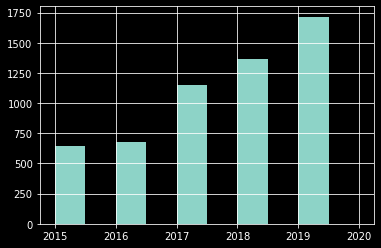

In [154]:
supply.start_year.hist()

Om het nog wat duidelijker te bekijken, gaan we ook de waardes van dichterbij bekijken. 

In [155]:
supply.start_year.value_counts()

2019    1716
2018    1364
2017    1152
2016     675
2015     641
2020       1
Name: start_year, dtype: int64

Zelfs als we rekening houden met het feit dat er in de beginjaren (het FAGG begon in 2014 met het bijhouden van deze cijfers) mogelijk nog niet heel veel werd gemeld, zien we een duidelijke stijging: meer dan een verdubbeling van het aantal meldingen in 2018 tov 2015. En 2019 zit nu al op het meest aantal meldingen, hoewel dit jaar nog niet om is.

### Conclusie: er worden steeds vaker medicijntekorten gemeld.

## Welke redenen komen het meest voor bij gemelde tekorten?
Hiervoor kijken we naar de kolom 'supply problem reason'. 

In [156]:
supply.supply_problem_reason.value_counts()

New batch(es) not yet available                  2675
Production problems                               843
Logistic problems                                 122
Other reason                                       92
Temporary suspension of the commercialisation      33
Packaging problems                                 25
FMD - Serialisation                                22
Patent dispute                                      6
Patent protection                                   5
Name: supply_problem_reason, dtype: int64

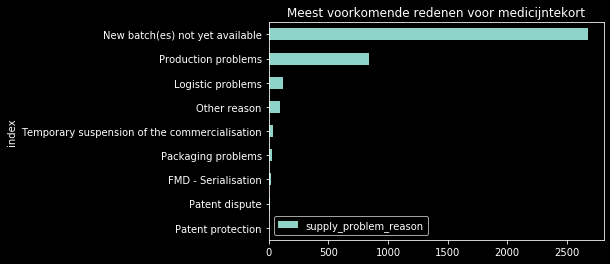

In [157]:
supply.supply_problem_reason.value_counts().reset_index().set_index('index').sort_values(by='supply_problem_reason').plot.barh(title='Meest voorkomende redenen voor medicijntekort')

In verreweg de meeste gevallen ging het om problemen met de beschikbaarheid van nieuwe voorraden. Op de tweede plaats ging het om productieproblemen en daarna om logistieke problemen. In een klein aantal gevallen waren er patentproblemen of zelfs een tijdelijke stopzetting van de commercialisatie.

### Conclusie: de meest voorkomende redenen zijn het onbeschikbaar zijn van nieuwe batches, productieproblemen en logistieke problemen. 
#### Het is mogelijk interessant om eens te kijken naar die redenen die juist weinig voorkomen, daar zit namelijk misschien ook wel een verhaal. 

## Welke fabrikanten komen het meest voor?
Hiervoor kijken we naar de column 'mah', de main authorisation holder. 

In [158]:
supply.mah.value_counts().head(10)

Sandoz                          828
Pfizer                          499
Mylan                           477
MSD Belgium                     250
Bayer                           235
Mylan EPD                       222
Teva Pharma Belgium             212
Sanofi Belgium                  144
Eurogenerics Afgekort "E.G."    113
Aspen Pharma Trading            112
Name: mah, dtype: int64

In [159]:
supply.mah.nunique()

248

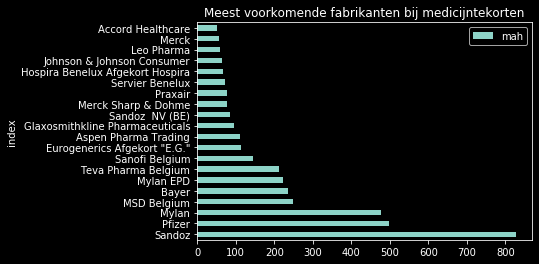

In [160]:
supply.mah.value_counts().reset_index().set_index('index').sort_values(by='mah', ascending=False).head(20).plot.barh(title='Meest voorkomende fabrikanten bij medicijntekorten')

We kijken even waar deze bedrijven vandaan komen. Sandoz is onderdeel van Novartis, een Zwitsers bedrijf. Pfizer is Amerikaans. Mylan staat geregistreerd in Nederland (vermoedelijk vanwege de belastingen, maar dat is een ander verhaal), maar heeft een hoofdzetel in de VS. MSD Belgium is de Belgische tak van een groot Amerikaans bedrijf. Bayer is Duits. Mylan EPD is weer een andere tak van Mylan. Teva Pharma Belgium is een dochteronderneming van het Israëlische Teva Pharmaceuticals. Sanofi Belgium is de Belgische tak van het Franse Sanofi. Eurogenerics is van oorsprong Belgisch en produceert generieke geneesmiddelen. Aspen Pharma Trading is van Aspen Pharmaceuticals, een Zuid-Afrikaans bedrijf.

Vooral interessant is hoe deze absolute cijfers zich verhouden tot het marktaandeel van deze bedrijven op de Belgische en internationale markt. Via de website van het CIB-Pharma vinden we een overzicht met de marktcijfers van het moving annual total van December 2018. Daaruit blijkt dat de top-20 grootste bedrijven op de Belgische markt de volgende zijn:

- EG Generics
- Pfizer
- AbbVie
- Novartis Pharma
- GSK België
- Sandoz
- Brystol-Myers Squibb
- MSD Belgium
- Janssen Pharmaceutica
- Bayer Pharmaceuticals
- Sanofi Belgium
- AstraZeneca
- Boehringer Ingelheim
- Gilead Sciences
- Tadeka Belgium
- Teva Pharmaceuticals Belgium
- Janssen & Janssen Cons
- VIIV Healthcare
- Novo-Nordisk
- Servier
- Gilead Sciences
- Tadeka Belgium
- Teva Pharmaceuticals Belgium
- Janssen & Janssen Cons
- VIIV Healthcare
- Novo-Nordisk
- Servier

Wat dan opvalt is dat hoewel EG Generics het grootste marktaandeel heeft (met afstand), het niet even hoog staat in onbeschikbaarheid van medicijnen. Pfizer staat op beide lijstjes hoog. Mylan staat op de derde plek in onbeschikbaarheid, maar heeft slechts een laag marktaandeel (niet in de top-20). MSD België staat wel in de top-20 in beide lijstjes, net als Bayer en Teva Pharma. Het lijkt er dus op dat de tweede grootste bedrijven qua tekorten (Pfizer en Sandoz) ook relatief hoog in het marktaandeel zitten (tweede en zesde plek). Vooral Sandoz komt heel vaak voor. 

Kanttekening hier: het kan dus zijn dat dit vooral komt omdat de bedrijven het goed rapporteren, niet per se omdat zij ook het hoogste aandeel hebben. Al is het wel opvallend dat het aantal gemelde tekorten van Sandoz bijna twee keer zo groot is als van Pfizer. 

### Conclusie: De twee bedrijven met de hoogste tekorten staan ook hoog in de top-20 qua marktaandeel in 2018, verder is het een mix. Het is waarschijnlijk interessanter om te gaan kijken naar cross-checks, zoals welke medicijntypes veel tekort worden gemeld, of welke bedrijven steeds langere/vaker tekorten melden. 

## Welke medicijnen en medicijntypes komen het meeste voor?
Hiervoor moeten we allereerst kijken naar de meest voorkomende stofnamen/merknamen, en deze vervolgens koppelen aan het juiste type medicijn.

In [161]:
supply.name.value_counts()

Oxygène             77
Ultravist           42
Bisoprolol          37
Ranitidine          37
Iomeron             32
Lipitor             32
Valtran             30
Quetiapine          29
Zantac              29
Mirtazapine         29
Tadalafil           27
Valsartan           27
Quetiapin           27
Dalacin             27
Serlain             27
Co-Valsartan        26
Celecoxib           26
Zolmitriptan        25
Gadovist            25
Paroxetine          25
Aciclovir           25
Loortan             25
Sildenafil          24
Ibuprofen           24
Diflucan            24
Olmesartan          24
Amlor               23
Gemcitabine         23
Metoprolol          23
Euthyrox            23
                    ..
Redomex              1
Flutiform            1
Mysoline             1
Nobiten              1
Laxido               1
Perdophen            1
Testocaps            1
Picato               1
Staurodorm           1
Cofact               1
Levocetiriteva       1
Stocrin              1
Vivotif    

In [162]:
supply.name_medicinal_product.value_counts()

Oxygène Médicinal Liquide Praxair 100 % v/v           77
Gadovist 1,0 mmol/ml                                  25
Ultravist 300 300 mg/ml                               23
Ultravist 370 370 mg/ml                               18
Valtran 71,197 mg/ml - 6,083 mg/ml                    18
Cerazette 75 µg                                       17
Lueva 75 µg                                           16
Amlor 5 mg                                            15
Marvelon 0,150 mg - 0,030 mg                          15
Iomeron 400 mg I/ml                                   15
Serlain 50 mg                                         15
Mercilon 0,150 mg - 0,020 mg                          14
Desloratadin Sandoz 5 mg                              13
Eusaprim Forte 160 mg - 800 mg                        13
Clozan 5 mg                                           12
Zantac 150 mg                                         12
Medrol A 16 mg                                        12
Lipanthylnano 145 mg           

We willen deze twee (name en name_medical_product) vergelijken omdat soms de naam van het product hetzelfde is, maar de precieze dosis niet. We zien dit meteen terug bij Ultravist: staat er 41 keer in, 22 keer met 300 mg/ml, 18 keer met 370 mg/ml. Als deze tekorten tegelijkertijd voorkomen, is het interessant om te zien of dit betekent dat een volledig medicijn niet meer beschikbaar is (een van onze andere vragen). We gaan ons eerst focussen op de medicijntypes, en daar hebben we de specifieke dosis niet voor nodig. We kijken dus alleen naar de eerste naam. 

In [163]:
supply.name.value_counts().reset_index().rename(columns={'index':'name', 'name':'count'}).to_csv('zorg/medicijnen.csv', index=False)